In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split

In [3]:
df_result_accuracy = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'accuracy'])
df_result_rmse = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'rmse'])

In [4]:
geo = pd.read_csv('../datasets/mehra.csv')
geo = geo.drop(columns=['Unnamed: 0'])
columns = ['Region', 'Zone', 'Type', 'Year', 'Season', 'Month', 'Day', 'Hour',
       'Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)
geo

,Region,Zone,Type,Year,Season,Month,Day,Hour,Latitude,Longitude,...,tp,blh,ssr,CVD60,no2,o3,so2,co,pm10,pm2.5
0,North West,Teesside Urban Area,Background Urban,1982,Fall,12,9,10,53.004256,-2.347284,...,-0.000384,-132.536379,1.764807e+05,0.253973,70.912242,13.886300,14.571613,1.281367,33.582153,18.641989
1,East of England,Greater Manchester Urban Area,Background Rural,1982,Spring,3,14,21,52.082833,-0.241892,...,1.647048,519.511962,-2.275298e+09,0.216665,-115661.469371,12.107172,31073.785918,0.134127,33.854881,18.635103
2,West Midlands,West Midlands,Industrial Urban,1986,Spring,8,1,3,53.130817,-2.706447,...,-0.001874,186.536382,2.484053e+06,0.171526,86.566005,18.724361,18.512337,1.583104,35.983265,18.627684
3,West Midlands,Nottingham Urban Area,Traffic Urban,1991,Summer,12,26,3,52.740293,-0.290470,...,-0.000337,38.110095,5.774116e+05,0.170889,64.279609,36.298044,17.351916,0.857752,41.550538,18.616868
4,North West,Eastern,Traffic Urban,1987,Summer,8,26,13,52.396919,-0.736334,...,-0.001544,2074.214906,7.529922e+06,0.153783,76.473575,17.750398,13.802166,1.442547,36.476342,18.639682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Greater London Authority,Bristol Urban Area,Traffic Urban,1982,Spring,9,18,21,52.166563,-0.790624,...,0.002033,493.620248,4.163936e+06,-0.020464,76.293832,17.714999,13.788669,1.438904,36.463592,18.643798
2996,Greater London Authority,Greater London Urban Area,Background Rural,2000,Fall,1,3,10,52.258917,-1.134958,...,0.001087,-144.589540,9.997366e+04,0.117326,97.104808,9.338329,25.826729,1.961520,35.629332,19.068493
2997,South East,Kingston upon Hull,Background Urban,1985,Winter,12,25,22,51.666340,-1.271156,...,0.001048,174.498423,1.232973e+06,0.207319,76.867158,17.834283,13.818176,1.439552,36.453567,18.642721
2998,North West,West Midlands Urban Area,Background Urban,1993,Summer,7,30,22,53.247531,-1.816050,...,0.002048,142.409021,9.300365e+06,0.158072,39.745866,16.522668,21.934194,0.629497,19.328282,18.642956


In [5]:
geo['Year'] = geo['Year'].apply(lambda x: str(x))
geo['Month'] = geo['Month'].apply(lambda x: str(x))
geo['Day'] = geo['Day'].apply(lambda x: str(x))
geo['Hour'] = geo['Hour'].apply(lambda x: str(x))

In [6]:
geo_train, geo_test = train_test_split(geo, test_size=0.08)
geo_train.reset_index(inplace=True, drop=True)
geo_test.reset_index(inplace=True, drop=True)

In [7]:
geo_types = get_nodes_type(geo)
geo_types

{'Region': 'disc',
 'Zone': 'disc',
 'Type': 'disc',
 'Year': 'disc',
 'Season': 'disc',
 'Month': 'disc',
 'Day': 'disc',
 'Hour': 'disc',
 'Latitude': 'cont',
 'Longitude': 'cont',
 'Altitude': 'cont',
 't2m': 'cont',
 'ws': 'cont',
 'wd': 'cont',
 'tp': 'cont',
 'blh': 'cont',
 'ssr': 'cont',
 'CVD60': 'cont',
 'no2': 'cont',
 'o3': 'cont',
 'so2': 'cont',
 'co': 'cont',
 'pm10': 'cont',
 'pm2.5': 'cont'}

In [8]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if geo_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [9]:
geo_coded, label_coder = code_categories(geo_train, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc)
geo_only_discrete, discrete_coder = discretization(geo_train, 'equal_frequency', columns_for_disc)

# Hill Climbing

# Дискретная структра + смешанные параметры

In [10]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_types)

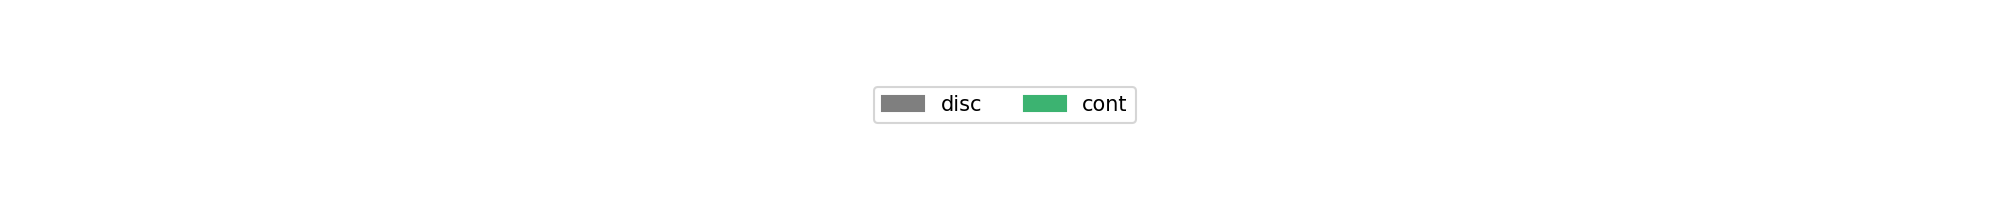

In [11]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [12]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [13]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [14]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

0
1
6
7
7
15
25
25
25
27
30
30
32
35
43
43
47
50
54
55
57
61
61
62
62
64
65
67
75
75
75
75
76
80
80
85
88
89
91
94
94
94
96
98
98
98
111
111
116
128
130
130
130
139
143
148
150
150
150
151
151
157
158
160
171
175
179
182
189
194
196
197
200
203
204
204
206
207
213
213
214
217
217
218
221
221
221
222
225
228
228
230
231
234
236
237
237
238


In [15]:
acc

{'Region': 0.18,
 'Zone': 0.23,
 'Type': 0.48,
 'Year': 0.05,
 'Season': 0.3,
 'Month': 0.05,
 'Day': 0.02,
 'Hour': 0.03}

In [16]:
rmse

{'Latitude': 1.41,
 'Longitude': 2.31,
 'Altitude': 95.81,
 't2m': 6.08,
 'ws': 4.05,
 'wd': 231.31,
 'tp': 1.75,
 'blh': 90128442.11,
 'ssr': 651981896.31,
 'CVD60': 0.04,
 'no2': 73676.68,
 'o3': 13.99,
 'so2': 32776.87,
 'co': 0.43,
 'pm10': 5.83,
 'pm2.5': 0.57}

In [17]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

# Смешанная структура + смешанные параметры

In [18]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_types)

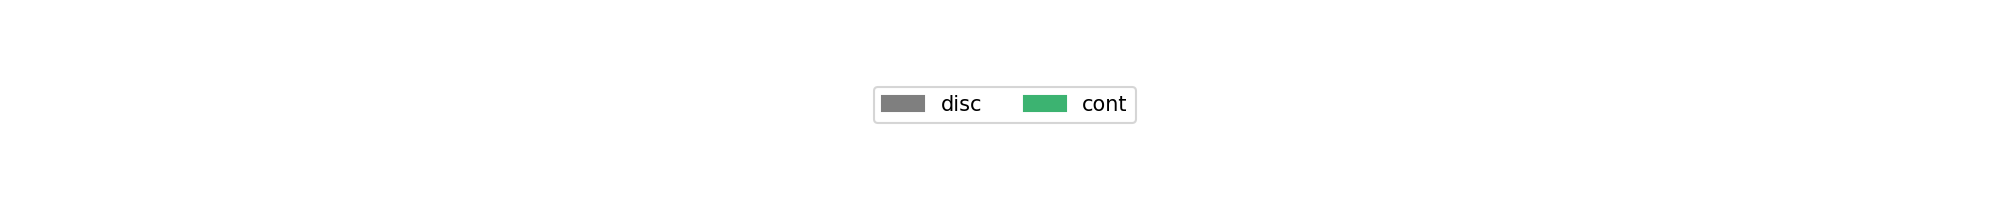

In [19]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [20]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [21]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [22]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

3
5
6
7
7
7
7
8
8
8
8
12
14
14
14
14
24
24
24
24
25
27
27
27
27
28
30
32
32
32
32
36
40
41
46
46
46
46
54
54
54
54
57
57
57
57
61
61
61
61
65
71
72
74
74
74
74
75
75
75
75
81
81
81
81
85
85
85
85
87
88
98
102
108
108
108
108
112
114
115
124
127
130
130
130
130
133
133
133
133
143
143
143
143
144
155
155
155
155
160
161
161
161
161
180
180
180
180
186
186
186
186
195
195
196
196
196
196
197
198
199
201
201
201
201
202
203
206
206
206
206
209
209
209
209
213
213
213
213
217
217
217
217
219
220
220
220
220
221
221
221
221
224
224
224
224
225
225
225
225
236
236


In [23]:
acc

{'Region': 0.21,
 'Zone': 0.23,
 'Type': 0.48,
 'Year': 0.04,
 'Season': 0.25,
 'Month': 0.06,
 'Day': 0.05,
 'Hour': 0.05}

In [24]:
rmse

{'Latitude': 1.11,
 'Longitude': 1.95,
 'Altitude': 95.83,
 't2m': 6.39,
 'ws': 3.32,
 'wd': 97.4,
 'tp': 1.62,
 'blh': 584.64,
 'ssr': 713809161.01,
 'CVD60': 0.04,
 'no2': 1804.46,
 'o3': 14.03,
 'so2': 34881.52,
 'co': 0.43,
 'pm10': 5.83,
 'pm2.5': 0.58}

In [25]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

# Дискретная стурктура + дискретные параметры

In [26]:
geo_new_types = {'Region': 'disc',
 'Zone': 'disc',
 'Type': 'disc',
 'Year': 'disc',
 'Season': 'disc',
 'Month': 'disc',
 'Day': 'disc',
 'Hour': 'disc',
 'Latitude': 'disc',
 'Longitude': 'disc',
 'Altitude': 'disc',
 't2m': 'disc',
 'ws': 'disc',
 'wd': 'disc',
 'tp': 'disc',
 'blh': 'disc',
 'ssr': 'disc',
 'CVD60': 'disc',
 'no2': 'disc',
 'o3': 'disc',
 'so2': 'disc',
 'co': 'disc',
 'pm10': 'disc',
 'pm2.5': 'disc'}

In [27]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_new_types)

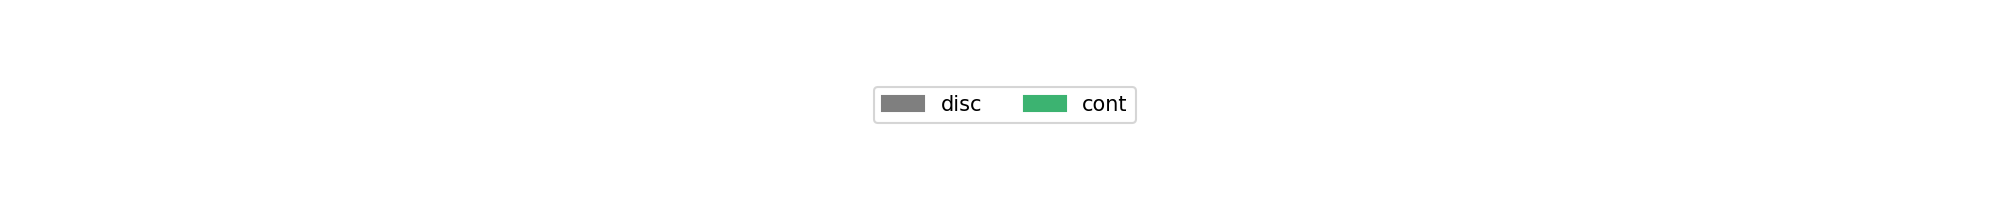

In [28]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [29]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [30]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [31]:
test_discrete = copy(geo_test)

In [32]:
test_discrete[columns_for_disc] = discrete_coder.transform(geo_test[columns_for_disc].values) 

In [33]:
for c in columns_for_disc:
    test_discrete[c] = test_discrete[c].apply(lambda x: int(x))
test_discrete

,Region,Zone,Type,Year,Season,Month,Day,Hour,Latitude,Longitude,...,tp,blh,ssr,CVD60,no2,o3,so2,co,pm10,pm2.5
0,West Midlands,Teesside Urban Area,Background Urban,1994,Summer,11,6,4,4,3,...,1,0,0,2,1,0,4,1,0,4
1,West Midlands,South East,Background Urban,1993,Spring,8,24,6,3,3,...,3,0,1,2,3,1,3,3,1,2
2,Greater London Authority,South West,Background Urban,1989,Spring,11,27,8,1,3,...,0,1,1,3,3,3,3,3,3,4
3,North West,West Midlands,Traffic Urban,1983,Fall,7,10,16,4,0,...,2,4,4,4,2,0,3,4,2,1
4,East Midlands,Yorkshire & Humberside,Background Urban,1981,Fall,5,14,21,1,0,...,4,3,3,1,3,2,2,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,North West,Greater London Urban Area,Background Urban,1982,Winter,4,5,14,3,0,...,2,3,3,3,2,1,2,4,3,1
236,North West,Greater Manchester Urban Area,Background Rural,1982,Fall,3,7,18,1,2,...,4,3,0,4,0,0,4,0,0,1
237,North West,Sheffield Urban Area,Traffic Urban,1985,Winter,9,1,11,3,4,...,2,3,2,3,4,0,4,0,0,1
238,Yorkshire and The Humber,South West,Background Urban,1998,Summer,8,29,23,1,0,...,0,1,4,1,0,4,0,0,4,0


In [34]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [35]:
acc

{'Region': 0.16,
 'Zone': 0.23,
 'Type': 0.48,
 'Year': 0.05,
 'Season': 0.3,
 'Month': 0.08,
 'Day': 0.0,
 'Hour': 0.02,
 'Latitude': 0.0,
 'Longitude': 0.0,
 'Altitude': 0.0,
 't2m': 0.0,
 'ws': 0.0,
 'wd': 0.0,
 'tp': 0.0,
 'blh': 0.0,
 'ssr': 0.0,
 'CVD60': 0.0,
 'no2': 0.0,
 'o3': 0.0,
 'so2': 0.0,
 'co': 0.0,
 'pm10': 0.0,
 'pm2.5': 0.0}

In [36]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [37]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[8:24]), columns=['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']), ['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5'], discrete_coder)

In [38]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[8:24]), columns=['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']), ['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5'], discrete_coder)

In [39]:
for c in ['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh', 'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']:
    m = mean_squared_error(invers_real[c], invers_pred[c], squared=False)
    df_result_rmse = df_result_rmse.append({'Parameter': c, 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

# Смешанная структура + дискретные параметры

In [40]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_new_types)

246: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:204: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:246: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:204: RuntimeWarning: overflow encountered in double_scalars
  delta_score = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in do

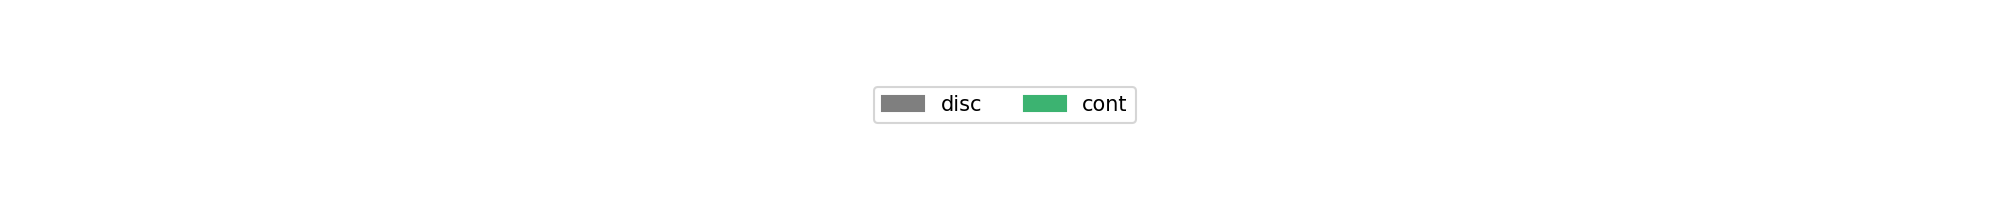

In [41]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [42]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [43]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [44]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [45]:
acc

{'Region': 0.12,
 'Zone': 0.23,
 'Type': 0.48,
 'Year': 0.04,
 'Season': 0.23,
 'Month': 0.05,
 'Day': 0.04,
 'Hour': 0.04,
 'Latitude': 0.0,
 'Longitude': 0.0,
 'Altitude': 0.0,
 't2m': 0.0,
 'ws': 0.0,
 'wd': 0.0,
 'tp': 0.0,
 'blh': 0.0,
 'ssr': 0.0,
 'CVD60': 0.0,
 'no2': 0.0,
 'o3': 0.0,
 'so2': 0.0,
 'co': 0.0,
 'pm10': 0.0,
 'pm2.5': 0.0}

In [46]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [47]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[8:24]), columns=['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']), ['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5'], discrete_coder)

In [48]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[8:24]), columns=['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']), ['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5'], discrete_coder)

In [49]:
for c in ['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh', 'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']:
    m = mean_squared_error(invers_real[c], invers_pred[c], squared=False)
    df_result_rmse = df_result_rmse.append({'Parameter': c, 'Strategy': 'HC', 'Alg':'M+D','rmse':m}, ignore_index=True)

# EVO

# Дискретная стурктура + смешанные параметры

In [50]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 40.6889
Generation num: 0
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 39.1072
Generation num: 1
max_depth: 3, no improvements: 0
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 39.089400000000005
Generation num: 2
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 37.4833
Generation num: 3
max_depth: 3, no improvements: 0
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 37.4833
Generation num: 4
max_depth: 3, no improvements: 1
Number of

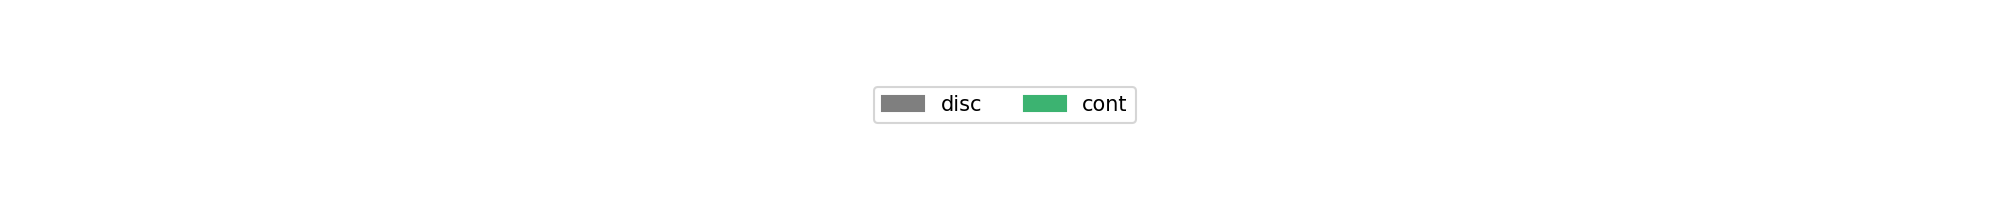

In [51]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [52]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [53]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [54]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

114


In [55]:
acc

{'Region': 0.21,
 'Zone': 0.23,
 'Type': 0.48,
 'Year': 0.05,
 'Season': 0.31,
 'Month': 0.08,
 'Day': 0.03,
 'Hour': 0.04}

In [56]:
rmse

{'Latitude': 1.11,
 'Longitude': 2.31,
 'Altitude': 95.66,
 't2m': 5.29,
 'ws': 3.32,
 'wd': 97.85,
 'tp': 1.62,
 'blh': 582.82,
 'ssr': 710582185.77,
 'CVD60': 0.04,
 'no2': 77270.04,
 'o3': 13.99,
 'so2': 35238.67,
 'co': 0.43,
 'pm10': 5.83,
 'pm2.5': 0.58}

In [57]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

# Смешанная структура + смешанные параметры

In [58]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 79.20455480724823
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.5 min
Best metric is 79.20455480724823
Generation num: 1
max_depth: 3, no improvements: 1
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.7 min
Best metric is 73.76014888570394
Generation num: 2
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 1.0 min
Best metric is 64.57818338291342
Generation num: 3
max_depth: 3, no improvements: 0
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 

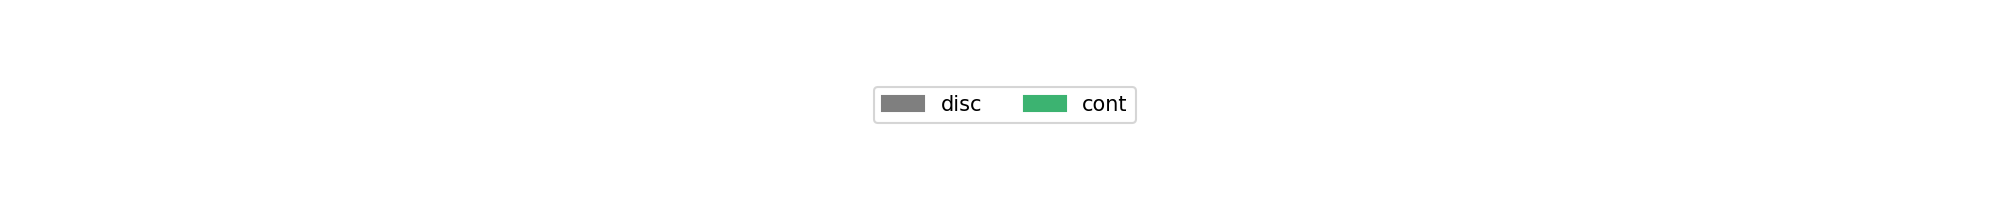

In [59]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [60]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [61]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [62]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

190


In [63]:
acc

{'Region': 0.21,
 'Zone': 0.23,
 'Type': 0.48,
 'Year': 0.05,
 'Season': 0.27,
 'Month': 0.1,
 'Day': 0.05,
 'Hour': 0.03}

In [64]:
rmse

{'Latitude': 1.11,
 'Longitude': 2.31,
 'Altitude': 95.69,
 't2m': 6.08,
 'ws': 3.32,
 'wd': 98.12,
 'tp': 1.62,
 'blh': 588.33,
 'ssr': 695950853.05,
 'CVD60': 0.04,
 'no2': 79248.47,
 'o3': 14.04,
 'so2': 35192.85,
 'co': 0.43,
 'pm10': 5.83,
 'pm2.5': 0.57}

In [65]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

# Дискретная структура + дискретные параметры

In [66]:
geo_new_types = {'Region': 'disc',
 'Zone': 'disc',
 'Type': 'disc',
 'Year': 'disc',
 'Season': 'disc',
 'Month': 'disc',
 'Day': 'disc',
 'Hour': 'disc',
 'Latitude': 'disc',
 'Longitude': 'disc',
 'Altitude': 'disc',
 't2m': 'disc',
 'ws': 'disc',
 'wd': 'disc',
 'tp': 'disc',
 'blh': 'disc',
 'ssr': 'disc',
 'CVD60': 'disc',
 'no2': 'disc',
 'o3': 'disc',
 'so2': 'disc',
 'co': 'disc',
 'pm10': 'disc',
 'pm2.5': 'disc'}

In [67]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 36.2015
Generation num: 0
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 36.2015
Generation num: 1
max_depth: 3, no improvements: 1
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 34.58389999999999
Generation num: 2
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 34.4094
Generation num: 3
max_depth: 3, no improvements: 0
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 33.073100000000004
Generation num: 4
max_depth: 3, no improvements: 0

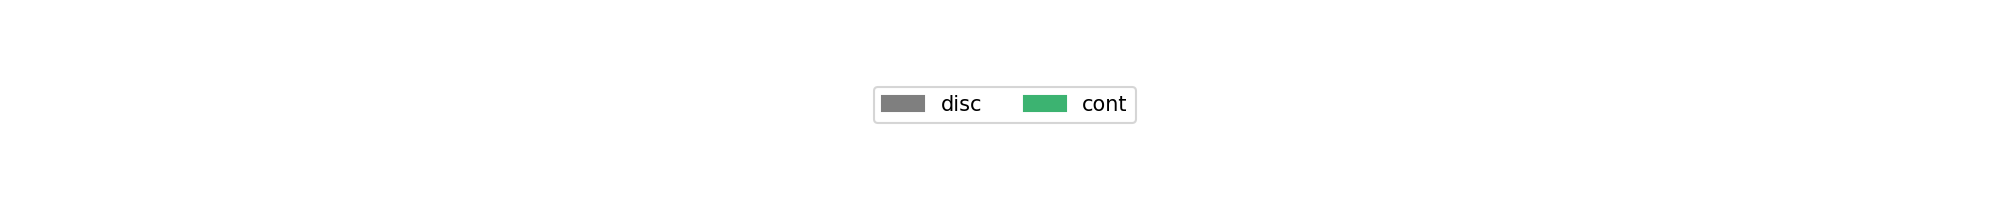

In [68]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [69]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [70]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [71]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [72]:
acc

{'Region': 0.21,
 'Zone': 0.22,
 'Type': 0.48,
 'Year': 0.12,
 'Season': 0.27,
 'Month': 0.07,
 'Day': 0.04,
 'Hour': 0.04,
 'Latitude': 0.0,
 'Longitude': 0.0,
 'Altitude': 0.0,
 't2m': 0.0,
 'ws': 0.0,
 'wd': 0.0,
 'tp': 0.0,
 'blh': 0.0,
 'ssr': 0.0,
 'CVD60': 0.0,
 'no2': 0.0,
 'o3': 0.0,
 'so2': 0.0,
 'co': 0.0,
 'pm10': 0.0,
 'pm2.5': 0.0}

In [73]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [74]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[8:24]), columns=['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']), ['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5'], discrete_coder)

In [75]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[8:24]), columns=['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']), ['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5'], discrete_coder)

In [76]:
for c in ['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh', 'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']:
    m = mean_squared_error(invers_real[c], invers_pred[c], squared=False)
    df_result_rmse = df_result_rmse.append({'Parameter': c, 'Strategy': 'evo', 'Alg':'D+D','rmse':m}, ignore_index=True)

# Смешанная структура + дискретные параметры

In [77]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 82.0846297513313
Generation num: 0
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 1.5 min
Best metric is 78.30445844567168
Generation num: 1
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 2.2 min
Best metric is 78.30445844567168
Generation num: 2
max_depth: 3, no improvements: 1
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 2.8 min
Best metric is 72.29742891191977
Generation num: 3
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 3.4 min
Best metric is 62.649178993323964
Generation num: 4
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operat

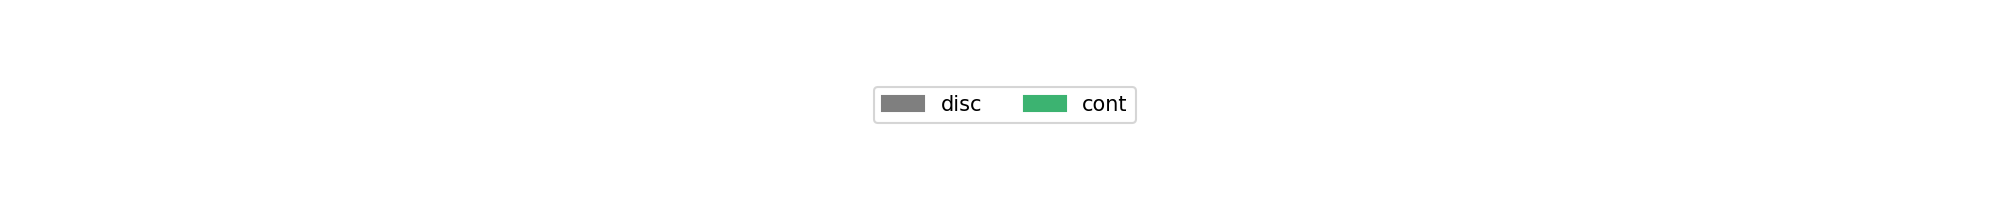

In [78]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [79]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [80]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [81]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [82]:
acc

{'Region': 0.21,
 'Zone': 0.23,
 'Type': 0.48,
 'Year': 0.05,
 'Season': 0.22,
 'Month': 0.08,
 'Day': 0.04,
 'Hour': 0.02,
 'Latitude': 0.0,
 'Longitude': 0.0,
 'Altitude': 0.0,
 't2m': 0.0,
 'ws': 0.0,
 'wd': 0.0,
 'tp': 0.0,
 'blh': 0.0,
 'ssr': 0.0,
 'CVD60': 0.0,
 'no2': 0.0,
 'o3': 0.0,
 'so2': 0.0,
 'co': 0.0,
 'pm10': 0.0,
 'pm2.5': 0.0}

In [83]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [84]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[8:24]), columns=['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']), ['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5'], discrete_coder)

In [85]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[8:24]), columns=['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']), ['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5'], discrete_coder)

In [86]:
for c in ['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh', 'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']:
    m = mean_squared_error(invers_real[c], invers_pred[c], squared=False)
    df_result_rmse = df_result_rmse.append({'Parameter': c, 'Strategy': 'evo', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [87]:
df_result_accuracy.to_csv('mehra_results_disc.csv', index=False)
df_result_rmse.to_csv('mehra_results_cont.csv', index=False)